Credentials to connect to the Cloudant database that holds the AIS data collected by Node-RED. You can generate a set of credentials for cloudant host, username and password from the IBM Cloud -> Data & Analytics -> Service Credentials tab. Or simply get DSX to generate the code for you from the Catalog service in the Watson Data Platform. (Check the url.)

In [12]:
# @hidden_cell
credentials_1 = {
  'password':"<enter>",
  'custom_url':'<enter>',
  'username':'<enter>'
}

Create an Apache Spark session to work with.

In [13]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

We can now import the AIS data received into a Node-RED flow and stored in Cloudant into a Spark database for bulk analysis.

In [14]:
cloudantdata = spark.read.format("org.apache.bahir.cloudant")\
.option("cloudant.host",credentials_1['custom_url'])\
.option("cloudant.username", credentials_1['username'])\
.option("cloudant.password",credentials_1['password'])\
.option("jsonstore.rdd.partitions",'5')\
.load("ships")

Let's just check that the data has come across OK by checking the schema that the import has automatically chosen for us...

In [15]:
cloudantdata.printSchema

<bound method DataFrame.printSchema of DataFrame[_id: string, _rev: string, bearing: bigint, callsign: string, destination: string, icon: string, iconColor: string, lat: double, layer: string, lon: double, name: string, payload: string, qos: bigint, retain: boolean, speed: double, topic: string, type: string, typeno: bigint]>

Now the data is in Apache Spark, we can count the number of instances very quickly:

In [16]:
cloudantdata.count()

2269

Let's look at the top three rows of data (json documents).

In [17]:
cloudantdata.head(3)

[Row(_id=u'03f9abf4770237eecf87f96445080109', _rev=u'1-7cfbfd1ef915d03b8d6566ec5000bb67', bearing=None, callsign=u'', destination=u'', icon=u'ship', iconColor=u'beige', lat=51.2748, layer=u'navigaton', lon=1.871, name=u'Inter Bank', payload=u'{"speed":""}', qos=0, retain=False, speed=None, topic=u'some/test/feed', type=u'RACON', typeno=102),
 Row(_id=u'03f9abf4770237eecf87f9644508103d', _rev=u'1-5d898ed131e4f7448fba55669147bf85', bearing=None, callsign=u'', destination=u'', icon=u'ship', iconColor=u'beige', lat=51.3233, layer=u'navigaton', lon=1.4527, name=u'Ramsgate \nChannel No. 2', payload=u'{"speed":""}', qos=0, retain=False, speed=None, topic=u'some/test/feed', type=u'Port hand Mark', typeno=124),
 Row(_id=u'03f9abf4770237eecf87f9644508174e', _rev=u'1-b69e61a56e04d5aa7c2086a1465f3f44', bearing=None, callsign=u'', destination=u'', icon=u'ship', iconColor=u'beige', lat=50.7247, layer=u'navigaton', lon=1.3145, name=u'Ridens SE', payload=u'{"speed":""}', qos=0, retain=False, speed=Non

Now we create a subset of the dataframe, taking the lat and lon coordinates of ships's positions.

In [18]:
shipCoords = cloudantdata.select('lat','lon')
shipCoords.show(4)

+-------+------+
|    lat|   lon|
+-------+------+
|51.2748| 1.871|
|51.3233|1.4527|
|50.7247|1.3145|
|50.5777|1.2262|
+-------+------+
only showing top 4 rows



By converting this lat/lon dataframe to a pandas dataframe, we can manipulate the data set more easily because of a wider range of available functions.  We ensure that the lat and lon data values are all floats, and records for which either value throws an error are discarded.  The final function converts the dataframe into an array format.

In [9]:
import pandas as pd
pd_df = shipCoords.toPandas()
pd_df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
pd_df.as_matrix()

array([[51.2748,  1.871 ],
       [51.3233,  1.4527],
       [50.7247,  1.3145],
       ...,
       [51.455 ,  2.623 ],
       [51.273 ,  3.846 ],
       [51.303 ,  2.659 ]])

Iterate through the dataframe to build an list of ship coordinates.  Take the first 100 positions so that we don't obliterate the grid we shall display them on.

In [10]:
positions = []
for index, row in pd_df.iterrows():
    positions.append([row[0],row[1]])

positions = positions[0:100]
print positions

[[51.2748, 1.871], [51.3233, 1.4527], [50.7247, 1.3145], [50.5777, 1.2262], [50.863, -1.312], [50.891, -1.4], [50.791, -1.106], [50.757, -1.531], [50.739, -1.149], [50.881, -1.299], [50.835, -1.323], [50.701, -1.032], [51.559, 2.954], [51.036, 1.938], [50.974, 2.282], [51.687, 3.304], [51.949, 4.063], [50.964, 1.853], [51.53, 2.28], [51.375, 3.108], [51.743, 3.89], [51.488, 3.396], [51.338, 3.207], [51.298, 1.921], [51.551, 1.797], [51.045, 2.009], [50.969, 1.228], [51.041, 2.37], [50.999, 2.263], [51.328, 1.42], [51.336, 3.19], [51.043, 2.359], [51.383, 1.921], [51.718, 3.248], [51.356, 3.898], [51.442, 2.201], [51.073, 1.765], [51.333, 3.136], [51.8, 3.342], [51.062, 1.216], [51.407, 2.049], [51.33, 1.421], [51.311, 3.223], [51.06, 1.542], [51.33, 1.422], [50.8673, 1.0367], [51.1873, 1.7487], [51.1417, 1.4813], [51.3236, 1.4353], [51.3233, 1.4527], [51.4055, 1.6187], [50.7498, 1.4541], [50.756, -1.531], [50.624, -1.047], [50.712, -1.988], [50.137, -1.101], [50.909, -1.381], [50.881, 

Display the ship positions on a graph.

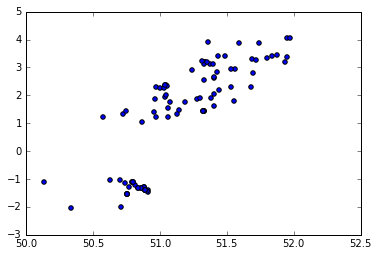

In [11]:
import matplotlib.pyplot as plt

for point in positions:
    plt.scatter(point[0],point[1])

plt.show()